Let's see if we can tune this model a bit better, and use kernelpls results as baseline. So, let's copy the lines from ~/research_code/baseline_prediction/modelList_twoClass_BA_splitFirst.R

In [31]:
library(caret)
library(caretEnsemble)
library(doParallel)
fname = '~/data/baseline_prediction/prs_start/gf_philip_03292020.csv'
phen = 'categ_all.4'
c1 = 'improvers'
c2 = 'stable_symptomatic'
clf_model = 'kernelpls'
impute = 'dti'
nfolds = 10
nreps = 10
ncores = 32
use_covs = FALSE
out_file = '/dev/null'

data = read.csv(fname)
data$sex_numeric = as.factor(data$sex_numeric)
data$SES_group3 = as.factor(data$SES_group3)
data$slf_fa = data$slf_all  # just to make it easier to filter out
var_names = c(# PRS
              'ADHD_PRS0.000100.orig', 'ADHD_PRS0.001000.orig',
              'ADHD_PRS0.010000.orig', 'ADHD_PRS0.050000.orig',
              'ADHD_PRS0.100000.orig', 'ADHD_PRS0.200000.orig',
              'ADHD_PRS0.300000.orig', 'ADHD_PRS0.400000.orig',
              'ADHD_PRS0.500000.orig',
              # DTI
              'atr_fa', 'cst_fa', 'cing_cing_fa', 'cing_hipp_fa', 'cc_fa',
              'ilf_fa', 'slf_fa', 'unc_fa',
              # demo
              'sex_numeric', 'SES_group3',
              # cog
              'FSIQ', 'SS_RAW', 'DS_RAW', 'PS_RAW', 'VMI.beery_RAW',
              # anat
              'cerebellum_white', 'cerebellum_grey', 'amygdala',
              'cingulate', 'lateral_PFC', 'OFC', 'striatum', 'thalamus'
              )

covar_names = c(# DTI
                'norm.rot', 'norm.trans', # base_age, gender,
                # cog
                # base_age, gender
                # anat
                'average_qc', # age, gender (but not ICV)
                # PRS
                sapply(1:10, function(x) sprintf('PC%02d', x)) # age, gender
                # demo
                # just base_age (as gender one was of the targets)
                )

if (use_covs) {
    data2 = data[, c(var_names, covar_names)]
} else {
    data2 = data[, var_names]
}

if (impute == 'dti') {
    use_me = !is.na(data2$slf_fa)
    data2 = data2[use_me, ]
    print(sprintf('Using %d observations, %d predictors.', nrow(data2),
                  ncol(data2))) 
} else if (impute == 'anat') {
    use_me = !is.na(data2$thalamus)
    data2 = data2[use_me, ]
    dti_cols = which(grepl(colnames(data2), pattern='_fa$'))
    data2 = data2[, -dti_cols]
    if (use_covs) {
        dti_cols = which(grepl(colnames(data2), pattern='^norm'))
        data2 = data2[, -dti_cols]
    }
    print(sprintf('Using %d observations, %d predictors.', nrow(data2),
                  ncol(data2)))
} else {
    use_me = TRUE
    print('No imputation needed')
}

# will need this later so training rows match data2
data = data[use_me, ]
data2$phen = as.factor(data[, phen])
dummies = dummyVars(phen ~ ., data = data2)
data3 = predict(dummies, newdata = data2)

# split traing and test between members of the same family
train_rows = c()
for (fam in unique(data$FAMID)) {
    fam_rows = which(data$FAMID == fam)
    if (length(fam_rows) == 1) {
        train_rows = c(train_rows, fam_rows[1])
    } else {
        # choose the youngest kid in the family for training
        train_rows = c(train_rows,
                       fam_rows[which.max(data[fam_rows, 'base_age'])])
    }
}
# data3 doesn't have the target column!
X_train <- data3[train_rows, ]
X_test <- data3[-train_rows, ]
y_train <- data2[train_rows,]$phen
y_test <- data2[-train_rows,]$phen

# imputation and feature engineering
set.seed(42)
pp_order = c('zv', 'nzv', 'corr', 'YeoJohnson', 'center', 'scale', 'bagImpute')
pp = preProcess(X_train, method = pp_order)
X_train = predict(pp, X_train)
X_test = predict(pp, X_test)

# remove linear combination variables
comboInfo <- findLinearCombos(X_train)
X_train = X_train[, -comboInfo$remove]
X_test = X_test[, -comboInfo$remove]

# selecting only kids in the 2 specified groups
keep_me = y_train==c1 | y_train==c2
X_train = X_train[keep_me, ]
y_train = factor(y_train[keep_me])
keep_me = y_test==c1 | y_test==c2
X_test = X_test[keep_me, ]
y_test = factor(y_test[keep_me])

registerDoParallel(ncores)
getDoParWorkers()

my_summary = function(data, lev = NULL, model = NULL) {
    tcs = twoClassSummary(data, lev=lev)
    a = c((tcs['Sens'] + tcs['Spec'])/2, tcs)
    names(a)[1] = 'BalancedAccuracy'
    return(a)
}

set.seed(42)
fitControl <- trainControl(method = "repeatedcv",
                           number = nfolds,
                           repeats = nreps,
                           savePredictions = 'final',
                           allowParallel = TRUE,
                           classProbs = TRUE,
                           summaryFunction=my_summary)

[1] "Using 165 observations, 32 predictors."


Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
“variable 'phen' is not a factor”


[1] 32

In [17]:
set.seed(42)
model_list <- caretList(X_train,
                        y_train,
                        trControl = fitControl,
                        methodList = c(clf_model, 'null'),
                        tuneList = NULL,
                        continue_on_fail = TRUE,
                        metric='BalancedAccuracy')

fit = model_list[[clf_model]]
resamps = resamples(list(fit=fit, tmp=fit))
bacc_stats = summary(resamps)$statistics$BalancedAccuracy['fit',]
cnames = sapply(names(bacc_stats), function(x) sprintf('BalancedAccuracy_%s', x))
names(bacc_stats) = cnames
auc_stats = summary(resamps)$statistics$ROC['fit',]
cnames = sapply(names(auc_stats), function(x) sprintf('AUC_%s', x))
names(auc_stats) = cnames
sens_stats = summary(resamps)$statistics$Sens['fit',]
cnames = sapply(names(sens_stats), function(x) sprintf('Sens_%s', x))
names(sens_stats) = cnames
spec_stats = summary(resamps)$statistics$Spec['fit',]
cnames = sapply(names(spec_stats), function(x) sprintf('Spec_%s', x))
names(spec_stats) = cnames

fit_pls = fit
resamps_pls = resamps

Warning message in trControlCheck(x = trControl, y = target):
“indexes not defined in trControl.  Attempting to set them ourselves, so each model in the ensemble will have the same resampling indexes.”


In [18]:
fit_pls

Partial Least Squares 

59 samples
33 predictors
 2 classes: 'improvers', 'stable_symptomatic' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 53, 53, 54, 53, 53, 52, ... 
Resampling results across tuning parameters:

  ncomp  BalancedAccuracy  ROC        Sens       Spec     
  1      0.5345833         0.5277778  0.4816667  0.5875000
  2      0.4912500         0.5205556  0.4983333  0.4841667
  3      0.4933333         0.5344444  0.4683333  0.5183333

BalancedAccuracy was used to select the optimal model using the largest value.
The final value used for the model was ncomp = 1.

There's certainly much to improve upon here. Can xgbTree do much better?

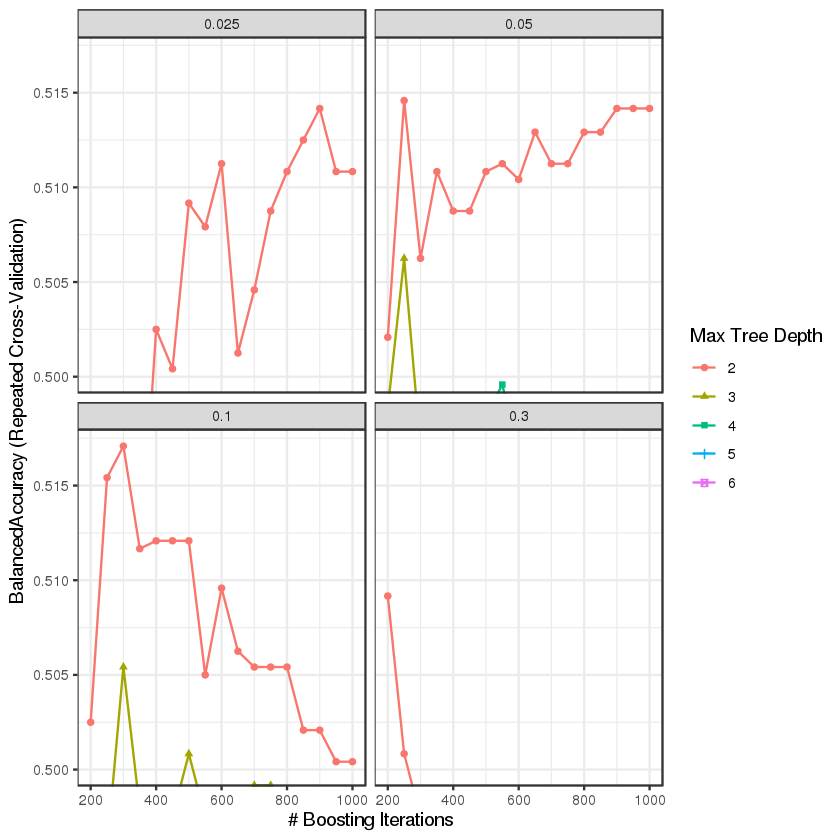

In [9]:
nrounds = 1000

tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = c(0.025, 0.05, 0.1, 0.3),
  max_depth = c(2, 3, 4, 5, 6),
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

set.seed(42)
xgb_tune <- caret::train(
  x = X_train,
  y = y_train,
  trControl = fitControl,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE,
    metric='BalancedAccuracy'
)

# helper function for the plots
tuneplot <- function(x, probs = .90) {
  ggplot(x) +
    coord_cartesian(ylim = c(.5, max(x$results$BalancedAccuracy))) + theme_bw()
}

tuneplot(xgb_tune)


Almost all max tree depth options are poor, and even the lower learning rates don't seem to be converging yet. Let's change it a bit:

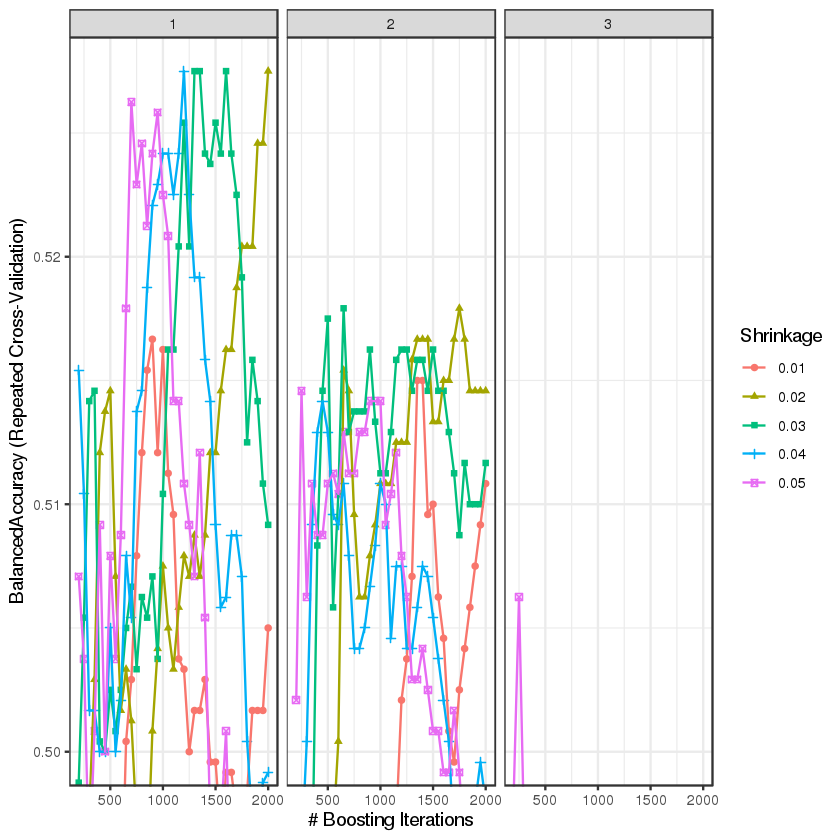

In [11]:
nrounds = 2000

tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = c(0.01, 0.02, 0.03, 0.04, .05),
  max_depth = c(1, 2, 3),
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

set.seed(42)
xgb_tune <- caret::train(
  x = X_train,
  y = y_train,
  trControl = fitControl,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE,
    metric='BalancedAccuracy'
)

# helper function for the plots
tuneplot <- function(x, probs = .90) {
  ggplot(x) +
    coord_cartesian(ylim = c(.5, max(x$results$BalancedAccuracy))) + theme_bw()
}

tuneplot(xgb_tune)


It looks like we'll do well at max_depth=1, nrounds=2000, learning at .03. Let's play with other parameters:

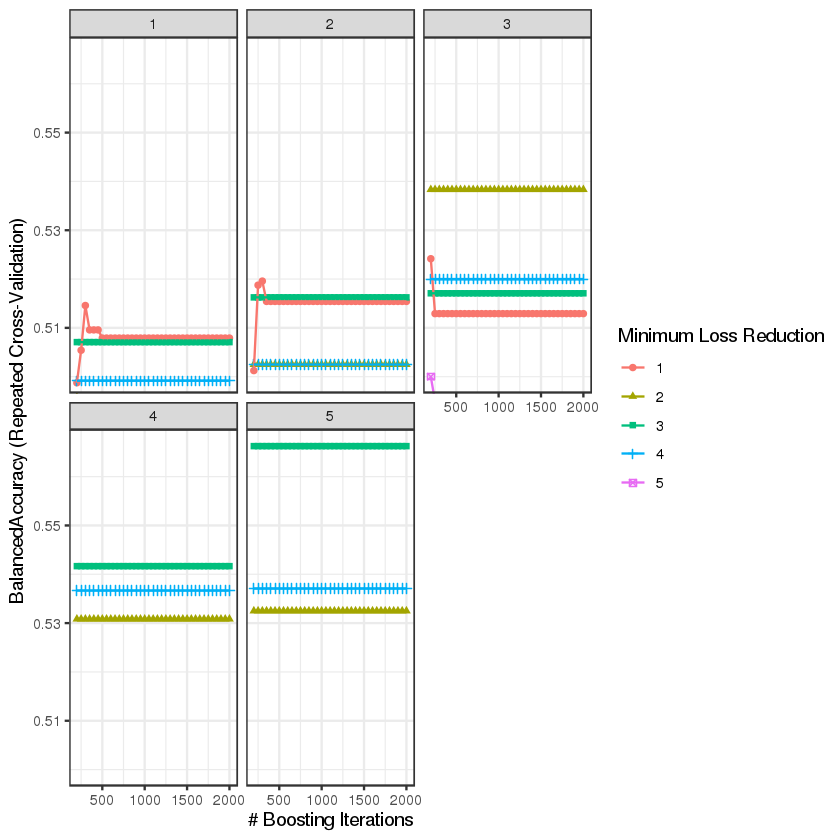

In [12]:
nrounds = 2000

tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = 0.03,
  max_depth = 1,
  gamma = 1:5,
  colsample_bytree = 1,
  min_child_weight = 1:5,
  subsample = 1
)

set.seed(42)
xgb_tune <- caret::train(
  x = X_train,
  y = y_train,
  trControl = fitControl,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE,
    metric='BalancedAccuracy'
)

# helper function for the plots
tuneplot <- function(x) {
  ggplot(x) +
    coord_cartesian(ylim = c(.5, max(x$results$BalancedAccuracy))) + theme_bw()
}

tuneplot(xgb_tune)


Can we go even higher if we increase min_child_weight?

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 185 rows containing missing values (geom_point).”


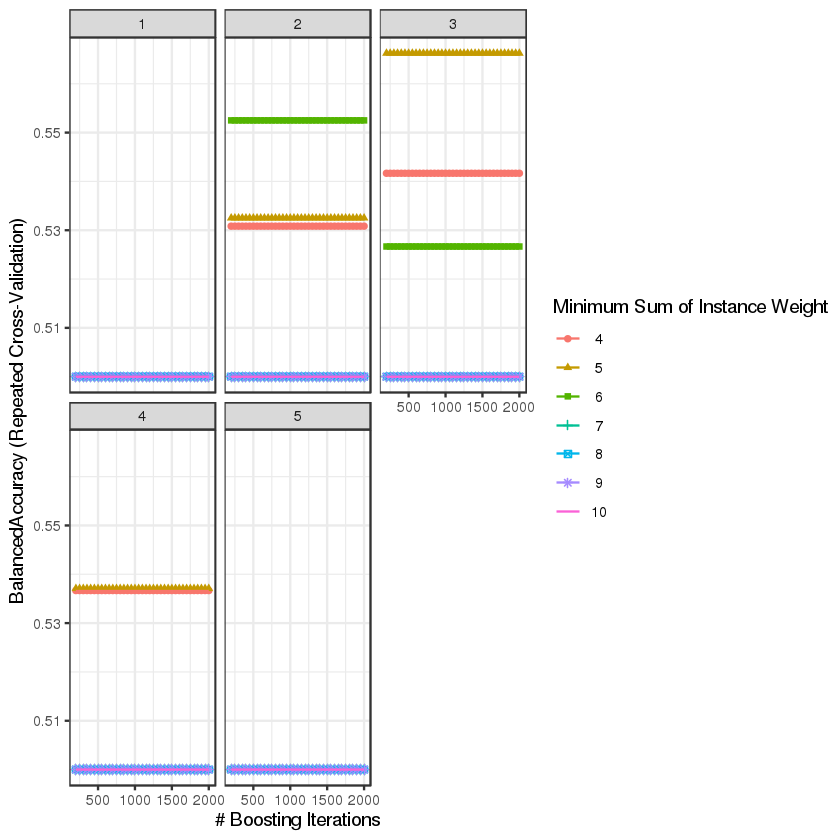

In [14]:
nrounds = 2000

tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = 0.03,
  max_depth = 1,
  gamma = 1:5,
  colsample_bytree = 1,
  min_child_weight = 4:10,
  subsample = 1
)

set.seed(42)
xgb_tune <- caret::train(
  x = X_train,
  y = y_train,
  trControl = fitControl,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE,
    metric='BalancedAccuracy'
)

# helper function for the plots
tuneplot <- function(x) {
  ggplot(x) +
    coord_cartesian(ylim = c(.5, max(x$results$BalancedAccuracy))) + theme_bw()
}

tuneplot(xgb_tune)


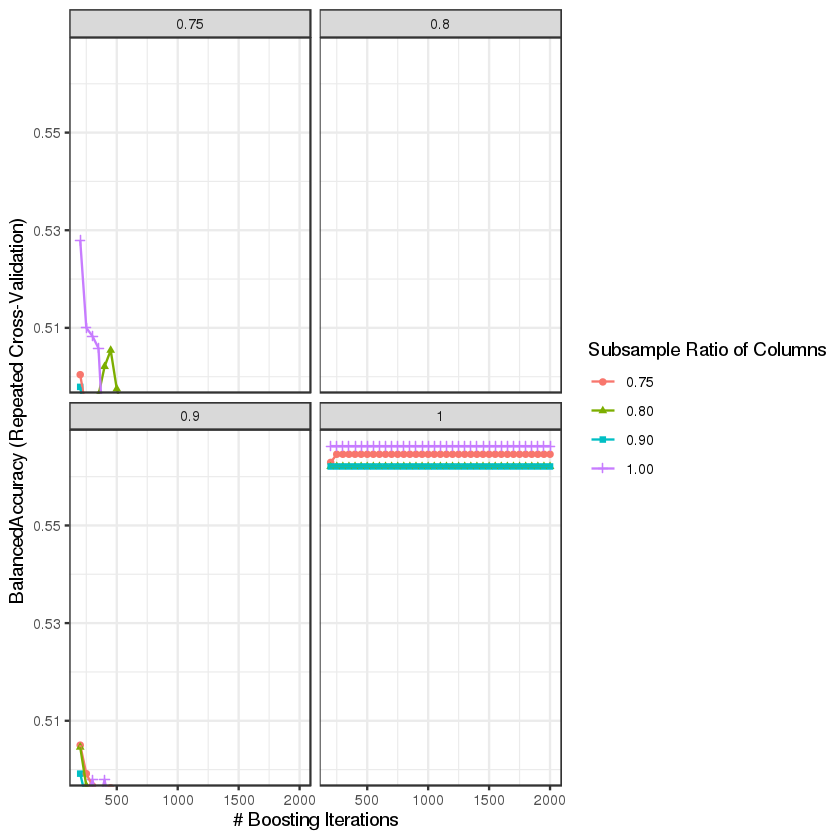

In [16]:
nrounds = 2000

tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = 0.03,
  max_depth = 1,
  gamma = 3,
  colsample_bytree = c(.75, .8, .9, 1),
  min_child_weight = 5,
  subsample = c(.75, .8, .9, 1)
)

set.seed(42)
xgb_tune <- caret::train(
  x = X_train,
  y = y_train,
  trControl = fitControl,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE,
    metric='BalancedAccuracy'
)

# helper function for the plots
tuneplot <- function(x) {
  ggplot(x) +
    coord_cartesian(ylim = c(.5, max(x$results$BalancedAccuracy))) + theme_bw()
}

tuneplot(xgb_tune)


Not much change... what if I add some regularization?

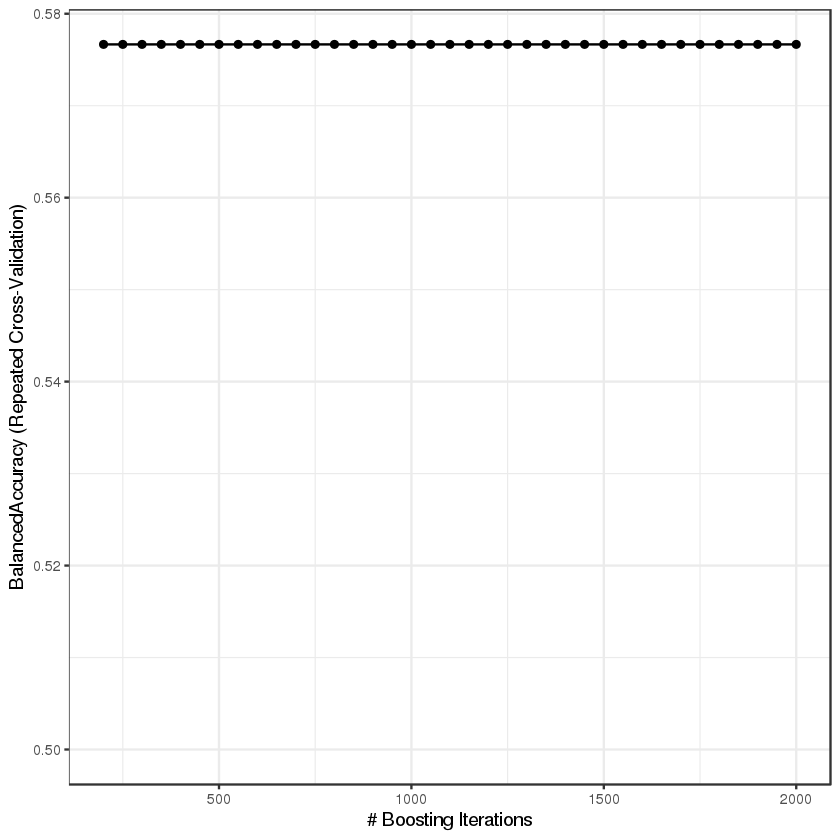

In [16]:
nrounds = 2000

tune_grid <- expand.grid(
  nrounds = seq(from = 200, to = nrounds, by = 50),
  eta = .1,
  max_depth = 1,
  gamma = 3,
  colsample_bytree = 1,
  min_child_weight = 5,
  subsample = 1
)

set.seed(42)
xgb_tune <- caret::train(
  x = X_train,
  y = y_train,
  trControl = fitControl,
  tuneGrid = tune_grid,
  method = "xgbTree",
  verbose = TRUE,
    metric='BalancedAccuracy'
)

# helper function for the plots
tuneplot <- function(x) {
  ggplot(x) +
    coord_cartesian(ylim = c(.5, max(x$results$BalancedAccuracy))) + theme_bw()
}

tuneplot(xgb_tune)


Nevermind... caret doesn't expose lambda and alpha in xgbtree. I might need to go directly to xgb.cv if this is not working... OK, after much playing, it doesn't look like it'll get much better than this.

In [10]:
xgb_tune$bestTune

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,200,1,0.1,3,1,5,1


Let's compare to our kernelpls baseline:

In [22]:
resamps = resamples(list(pls=fit_pls, xgb=xgb_tune))

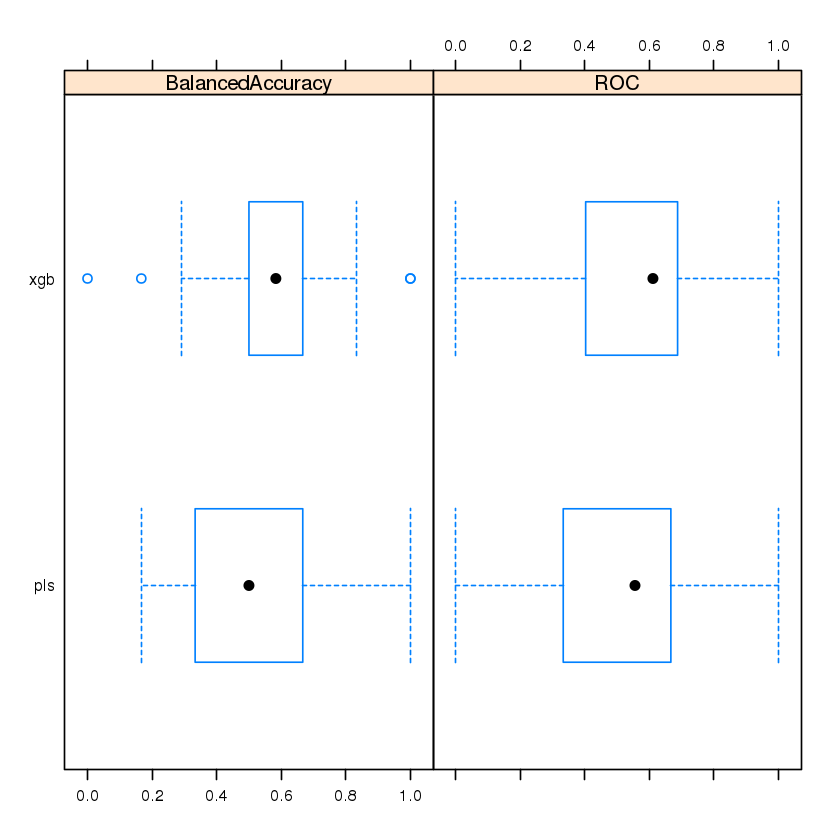

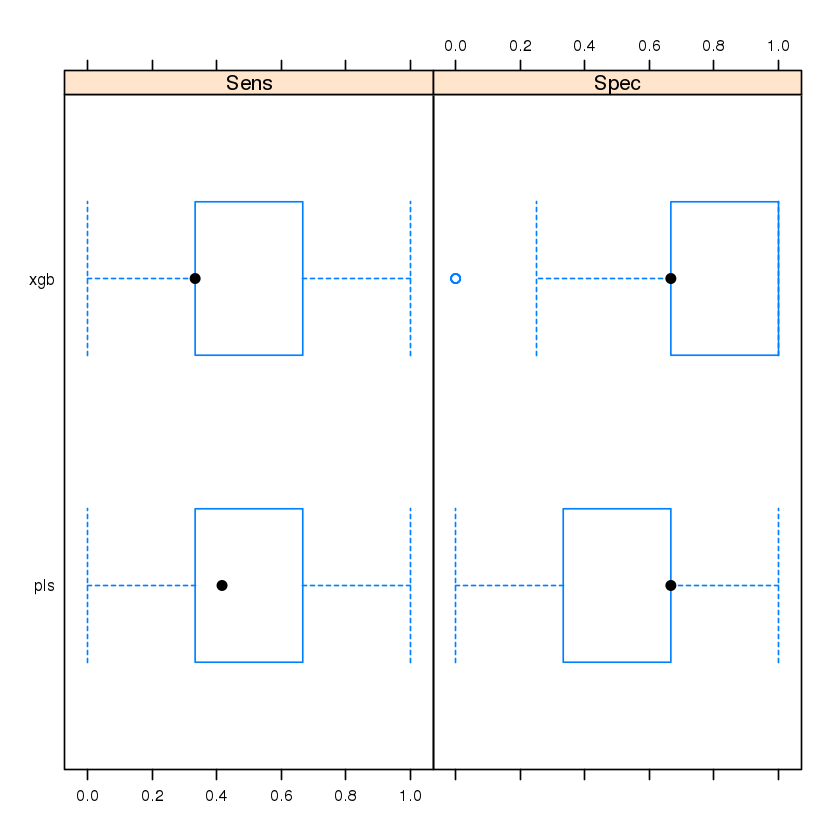

In [24]:
bwplot(resamps, layout = c(2, 1))

Not terribly different. Do they differ by much on how well they generalize?

In [28]:
fit = fit_pls
preds_class = predict.train(fit, newdata=X_test)
preds_probs = predict.train(fit, newdata=X_test, type='prob')
dat = cbind(data.frame(obs = y_test, pred = preds_class), preds_probs)
mcs = my_summary(dat, lev=colnames(preds_probs))
print(c(mcs['BalancedAccuracy'], mcs['ROC'], mcs['Sens'], mcs['Spec']))

fit = xgb_tune
preds_class = predict.train(fit, newdata=X_test)
preds_probs = predict.train(fit, newdata=X_test, type='prob')
dat = cbind(data.frame(obs = y_test, pred = preds_class), preds_probs)
mcs = my_summary(dat, lev=colnames(preds_probs))
print(c(mcs['BalancedAccuracy'], mcs['ROC'], mcs['Sens'], mcs['Spec']))


BalancedAccuracy              ROC             Sens             Spec 
       0.5222222        0.4666667        0.4444444        0.6000000 
BalancedAccuracy              ROC             Sens             Spec 
       0.5111111        0.5444444        0.2222222        0.8000000 


Either one is not great... I'm afraid the imputation might be washing out the results. Can I run xgbTree without imputation?

# Missing data

Let's see what we can do if we don't do any imputation.

In [44]:
library(caret)
library(caretEnsemble)
library(doParallel)
fname = '~/data/baseline_prediction/prs_start/gf_philip_03292020.csv'
phen = 'categ_all.4'
c1 = 'improvers'
c2 = 'stable_symptomatic'
clf_model = 'kernelpls'
nfolds = 10
nreps = 10
ncores = 32
use_covs = FALSE
out_file = '/dev/null'

data = read.csv(fname)
data$sex_numeric = as.factor(data$sex_numeric)
data$SES_group3 = as.factor(data$SES_group3)
data$slf_fa = data$slf_all  # just to make it easier to filter out
var_names = c(# PRS
              'ADHD_PRS0.000100.orig', 'ADHD_PRS0.001000.orig',
              'ADHD_PRS0.010000.orig', 'ADHD_PRS0.050000.orig',
              'ADHD_PRS0.100000.orig', 'ADHD_PRS0.200000.orig',
              'ADHD_PRS0.300000.orig', 'ADHD_PRS0.400000.orig',
              'ADHD_PRS0.500000.orig',
              # DTI
              'atr_fa', 'cst_fa', 'cing_cing_fa', 'cing_hipp_fa', 'cc_fa',
              'ilf_fa', 'slf_fa', 'unc_fa',
              # demo
              'sex_numeric', 'SES_group3',
              # cog
              'FSIQ', 'SS_RAW', 'DS_RAW', 'PS_RAW', 'VMI.beery_RAW',
              # anat
              'cerebellum_white', 'cerebellum_grey', 'amygdala',
              'cingulate', 'lateral_PFC', 'OFC', 'striatum', 'thalamus'
              )

covar_names = c(# DTI
                'norm.rot', 'norm.trans', # base_age, gender,
                # cog
                # base_age, gender
                # anat
                'average_qc', # age, gender (but not ICV)
                # PRS
                sapply(1:10, function(x) sprintf('PC%02d', x)) # age, gender
                # demo
                # just base_age (as gender one was of the targets)
                )

if (use_covs) {
    data2 = data[, c(var_names, covar_names)]
} else {
    data2 = data[, var_names]
}

data2$phen = as.factor(data[, phen])
dummies = dummyVars(phen ~ ., data = data2)
data3 = predict(dummies, newdata = data2)
# remove extra dummies for sex and SES
data3 = data3[, -c(19, 22)]

# split traing and test between members of the same family
train_rows = c()
for (fam in unique(data$FAMID)) {
    fam_rows = which(data$FAMID == fam)
    if (length(fam_rows) == 1) {
        train_rows = c(train_rows, fam_rows[1])
    } else {
        # choose the youngest kid in the family for training
        train_rows = c(train_rows,
                       fam_rows[which.max(data[fam_rows, 'base_age'])])
    }
}
    

# data3 doesn't have the target column!
X_train <- data3[train_rows, ]
X_test <- data3[-train_rows, ]
y_train <- data2[train_rows,]$phen
y_test <- data2[-train_rows,]$phen

# selecting only kids in the 2 specified groups
keep_me = y_train==c1 | y_train==c2
X_train = X_train[keep_me, ]
y_train = factor(y_train[keep_me])
keep_me = y_test==c1 | y_test==c2
X_test = X_test[keep_me, ]
y_test = factor(y_test[keep_me])

registerDoParallel(ncores)
getDoParWorkers()

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
“variable 'phen' is not a factor”


[1] 32

In [49]:
library(xgboost)
# special formating for xgboost
dtrain <- xgb.DMatrix(data = as.matrix(X_train), label = as.numeric(y_train)-1, missing=NA) 
dtest <- xgb.DMatrix(data = as.matrix(X_test), label = as.numeric(y_test)-1, missing=NA)

In [50]:
params <- list(booster = "gbtree", objective = "binary:logistic", eta=0.002, gamma=5, max_depth=1,
               min_child_weight=2, subsample=.75, colsample_bytree=.75, alpha=.1, lambda=15)
xgbcv <- xgb.cv(params = params, data = dtrain, nrounds = 400, nfold = 5, showsd = T, stratified = T,
                print_maximize = T, every_n = 10, early_stopping_rounds = 40, eval_metric='auc')

[1]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
Multiple eval metrics are present. Will use test_auc for early stopping.
Will train until test_auc hasn't improved in 40 rounds.

[2]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[3]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[4]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[5]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[6]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[7]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[8]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[9]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[10]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[11]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[12]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[13]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[14]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[15]	train-auc:0.500000+0

In [90]:
# after I figure out a good range to try, here's some code for a grid search using several different seeds:
best_param <- list()
best_seednumber <- 1234
best_auc <- 0
best_auc_index <- 0

set.seed(42)
for (iter in 1:200) {
  param <- list(objective = "binary:logistic",
                eval_metric = "auc",
                max_depth = 1,#sample(6:10, 1),
                eta = runif(1, .01, .3),
                subsample = runif(1, .5, .8),
                colsample_bytree = runif(1, .3, .7), 
                min_child_weight = sample(1:10, 1),
                gamma = sample(1:10, 1),
                alpha = runif(1, .5, .8),
                lambda = runif(1, .5, .8)
  )
  cv.nround <-  3000
  cv.nfold <-  5
  seed.number  <-  sample.int(10000, 1)
  set.seed(seed.number)
  mdcv <- xgb.cv(data = dtrain, params = param,  
                 nfold = cv.nfold, nrounds = cv.nround,
                 verbose = F, early_stopping_rounds = 8, maximize = TRUE)

  max_auc_index  <-  mdcv$best_iteration
  max_auc <-  mdcv$evaluation_log[max_auc_index]$test_auc_mean

  if (max_auc > best_auc) {
    best_auc <- max_auc
    best_auc_index <- max_auc_index
    best_seednumber <- seed.number
    best_param <- param
  }
}

# The best index (min_rmse_index) is the best "nround" in the model
nround = best_auc_index
set.seed(best_seednumber)
xg_mod <- xgboost(data = dtest, params = best_param, nround = nround, verbose = F)

# Check error in testing data
yhat_xg <- predict(xg_mod, dtest)
print(best_auc)
print(best_param)

[1] 0.6681748
$objective
[1] "binary:logistic"

$eval_metric
[1] "auc"

$max_depth
[1] 1

$eta
[1] 0.2458014

$subsample
[1] 0.5123076

$colsample_bytree
[1] 0.3642717

$min_child_weight
[1] 2

$gamma
[1] 1

$alpha
[1] 0.7541482

$lambda
[1] 0.6653455



This is out best result so far... what happens if I start playing with lambda and alpha?

In [120]:
# after I figure out a good range to try, here's some code for a grid search using several different seeds:
best_param <- list()
best_seednumber <- 1234
best_auc <- 0
best_auc_index <- 0

set.seed(42)
for (iter in 1:400) {
  param <- list(objective = "binary:logistic",
                eval_metric = "auc",
                max_depth = 1,#sample(6:10, 1),
                eta = runif(1, .01, .3),
                subsample = runif(1, .5, .8),
                colsample_bytree = runif(1, .2, .7), 
                min_child_weight = sample(1:10, 1),
                gamma = sample(1:10, 1),
                alpha = runif(1, 0, .5), # default 0, higher more conservative
                lambda = 1  # default 1, higher more conservative
  )
  cv.nround <-  3000
  cv.nfold <-  5
  seed.number  <-  sample.int(10000, 1)
  set.seed(seed.number)
  mdcv <- xgb.cv(data = dtrain, params = param,  
                 nfold = cv.nfold, nrounds = cv.nround,
                 verbose = F, early_stopping_rounds = 8, maximize = TRUE)

  max_auc_index  <-  mdcv$best_iteration
  max_auc <-  mdcv$evaluation_log[max_auc_index]$test_auc_mean

  if (max_auc > best_auc) {
    best_auc <- max_auc
    best_auc_index <- max_auc_index
    best_seednumber <- seed.number
    best_param <- param
  }
}

# The best index (min_rmse_index) is the best "nround" in the model
nround = best_auc_index
set.seed(best_seednumber)
xg_mod <- xgboost(data = dtrain, params = best_param, nround = nround, verbose = F)

# Check error in testing data
yhat_xg <- predict(xg_mod, dtest)
print(best_auc)
print(best_param)

[1] 0.6722788
$objective
[1] "binary:logistic"

$eval_metric
[1] "auc"

$max_depth
[1] 1

$eta
[1] 0.2122554

$subsample
[1] 0.5096954

$colsample_bytree
[1] 0.2498723

$min_child_weight
[1] 3

$gamma
[1] 1

$alpha
[1] 0.3656571

$lambda
[1] 1



OK, so this is the best I can do in training... how well does it do for testing?

In [129]:
y_preds = ifelse (yhat_xg > 0.5,1,0)
confusionMatrix (factor(y_preds), factor(as.numeric(y_test)-1))

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 18 23
         1  4  3
                                          
               Accuracy : 0.4375          
                 95% CI : (0.2948, 0.5882)
    No Information Rate : 0.5417          
    P-Value [Acc > NIR] : 0.944228        
                                          
                  Kappa : -0.0623         
                                          
 Mcnemar's Test P-Value : 0.000532        
                                          
            Sensitivity : 0.8182          
            Specificity : 0.1154          
         Pos Pred Value : 0.4390          
         Neg Pred Value : 0.4286          
             Prevalence : 0.4583          
         Detection Rate : 0.3750          
   Detection Prevalence : 0.8542          
      Balanced Accuracy : 0.4668          
                                          
       'Positive' Class : 0               
                                    

In [137]:
dat = cbind(data.frame(obs = factor(as.numeric(y_test)-1), pred = factor(y_preds), yhat_xg))
colnames(dat)[3] = '0'
twoClassSummary(dat, lev=c(0,1))

ROC      Sens      Spec 
       NA 0.8181818 0.1153846

In [138]:
summary(dat)

 obs    pred         0         
 0:22   0:41   Min.   :0.2207  
 1:26   1: 7   1st Qu.:0.3354  
               Median :0.3633  
               Mean   :0.3846  
               3rd Qu.:0.4580  
               Max.   :0.5255  

In [144]:
y_preds = factor(ifelse (yhat_xg > 0.5,'stable_symptomatic','improvers'))
confusionMatrix (y_preds, y_test)

Confusion Matrix and Statistics

                    Reference
Prediction           improvers stable_symptomatic
  improvers                 18                 23
  stable_symptomatic         4                  3
                                          
               Accuracy : 0.4375          
                 95% CI : (0.2948, 0.5882)
    No Information Rate : 0.5417          
    P-Value [Acc > NIR] : 0.944228        
                                          
                  Kappa : -0.0623         
                                          
 Mcnemar's Test P-Value : 0.000532        
                                          
            Sensitivity : 0.8182          
            Specificity : 0.1154          
         Pos Pred Value : 0.4390          
         Neg Pred Value : 0.4286          
             Prevalence : 0.4583          
         Detection Rate : 0.3750          
   Detection Prevalence : 0.8542          
      Balanced Accuracy : 0.4668          
             

In [150]:
dat = data.frame(obs = y_test, pred = y_preds, improvers=yhat_xg)
twoClassSummary(dat, lev=levels(y_test))

ROC      Sens      Spec 
0.5419580 0.8181818 0.1153846

Yeah, there might be an issue with the test set... 

# LOOCV

What if I take the same approach I've been planning for the RNAseq project, and use LOOCV? Then I'd also use FAMID as a covariate, and check it out.

In [2]:
library(caret)
library(caretEnsemble)
library(doParallel)
library(xgboost)
fname = '~/data/baseline_prediction/prs_start/gf_philip_03292020.csv'
phen = 'categ_all.4'
c1 = 'improvers'
c2 = 'stable_symptomatic'
ncores = 32

data = read.csv(fname)
data$sex_numeric = as.factor(data$sex_numeric)
data$SES_group3 = as.factor(data$SES_group3)
data$slf_fa = data$slf_all  # just to make it easier to filter out
var_names = c(# PRS
              'ADHD_PRS0.000100.orig', 'ADHD_PRS0.001000.orig',
              'ADHD_PRS0.010000.orig', 'ADHD_PRS0.050000.orig',
              'ADHD_PRS0.100000.orig', 'ADHD_PRS0.200000.orig',
              'ADHD_PRS0.300000.orig', 'ADHD_PRS0.400000.orig',
              'ADHD_PRS0.500000.orig',
              # DTI
              'atr_fa', 'cst_fa', 'cing_cing_fa', 'cing_hipp_fa', 'cc_fa',
              'ilf_fa', 'slf_fa', 'unc_fa',
              # demo
              'sex_numeric', 'SES_group3',
              # cog
              'FSIQ', 'SS_RAW', 'DS_RAW', 'PS_RAW', 'VMI.beery_RAW',
              # anat
              'cerebellum_white', 'cerebellum_grey', 'amygdala',
              'cingulate', 'lateral_PFC', 'OFC', 'striatum', 'thalamus'
              )

# data2 = data[, c(var_names, 'FAMID')]
data2 = data[, var_names]

data2$phen = as.factor(data[, phen])
# data2$FAMID = as.factor(data$FAMID)
dummies = dummyVars(phen ~ ., data = data2)
data3 = predict(dummies, newdata = data2)

# selecting only kids in the 2 specified groups
keep_me = data2$phen==c1 | data2$phen==c2
X = data3[keep_me, ]
y = factor(data2[keep_me, 'phen'])

# data3 doesn't have the target column!
train_rows = setdiff(1:nrow(X), 1)
X_train <- X[train_rows, ]
X_test <- X[-train_rows, ]
y_train <- y[train_rows]
y_test <- y[-train_rows]

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
“variable 'phen' is not a factor”


For now, let's get LOOCV to work:

In [69]:
y_probs = c()
for (test_row in 1:nrow(X)) {
    train_rows = setdiff(1:nrow(X), test_row)
    X_train <- X[train_rows, ]
    X_test <- X[-train_rows, ]
    y_train <- y[train_rows]
    y_test <- y[-train_rows]

    dtrain <- xgb.DMatrix(data = as.matrix(X_train), label = as.numeric(y_train)-1, missing=NA)
    dtest <- xgb.DMatrix(data = t(as.matrix(X_test)), label = as.numeric(y_test)-1, missing=NA)
    
    best_param <- list()
    best_seednumber <- 1234
    best_auc <- 0
    best_auc_index <- 0

    set.seed(42)
    for (iter in 1:400) {
      param <- list(objective = "binary:logistic",
                    eval_metric = "auc",
                    max_depth = 1,#sample(6:10, 1),
                    eta = runif(1, .1, .4),
                    subsample = runif(1, .4, .8),
                    colsample_bytree = runif(1, .2, .4), 
                    min_child_weight = sample(1:10, 1),
                    gamma = sample(1:10, 1),
                    alpha = 0, #runif(1, 0, 5), # default 0, higher more conservative
                    lambda = 1 #runif(1, 1, 5)  # default 1, higher more conservative
      )
      cv.nround <-  3000
      cv.nfold <-  5
      seed.number  <-  sample.int(10000, 1)
      set.seed(seed.number)
      mdcv <- xgb.cv(data = dtrain, params = param,  
                     nfold = cv.nfold, nrounds = cv.nround,
                     verbose = F, early_stopping_rounds = 10, maximize = TRUE)

      max_auc_index  <-  mdcv$best_iteration
      max_auc <-  mdcv$evaluation_log[max_auc_index]$test_auc_mean

      if (max_auc > best_auc) {
        best_auc <- max_auc
        best_auc_index <- max_auc_index
        best_seednumber <- seed.number
        best_param <- param
      }
    }

    nround = best_auc_index
    set.seed(best_seednumber)
    xg_mod <- xgboost(data = dtrain, params = best_param, nround = nround, verbose = F)

    # Check error in testing data
    message(test_row)
    print(best_auc)
    y_probs = c(y_probs, predict(xg_mod, dtest))
}

1



[1] 0.5881752


2



[1] 0.5852048


3



[1] 0.6115836


4



[1] 0.5796062


5



[1] 0.5948584


6



[1] 0.5765138


7



[1] 0.5979496


8



[1] 0.584505


9



[1] 0.571019


10



[1] 0.5970452


11



[1] 0.566196


12



[1] 0.5881368


13



[1] 0.6057034


14



[1] 0.5789496


15



Now we do some optimization:

In [ ]:
# special formating for xgboost
dtrain <- xgb.DMatrix(data = as.matrix(X), label = as.numeric(y)-1, missing=NA)

In [66]:
# after I figure out a good range to try, here's some code for a grid search using several different seeds:
best_param <- list()
best_seednumber <- 1234
best_auc <- 0
best_auc_index <- 0

set.seed(42)
for (iter in 1:400) {
  param <- list(objective = "binary:logistic",
                eval_metric = "auc",
                max_depth = 1,#sample(6:10, 1),
                eta = runif(1, .1, .4),
                subsample = runif(1, .4, .8),
                colsample_bytree = runif(1, .2, .4), 
                min_child_weight = sample(1:10, 1),
                gamma = sample(1:10, 1),
                alpha = 0, #runif(1, 0, 5), # default 0, higher more conservative
                lambda = 1 #runif(1, 1, 5)  # default 1, higher more conservative
  )
  cv.nround <-  3000
  cv.nfold <-  5
  seed.number  <-  sample.int(10000, 1)
  set.seed(seed.number)
  mdcv <- xgb.cv(data = dtrain, params = param,  
                 nfold = cv.nfold, nrounds = cv.nround,
                 verbose = F, early_stopping_rounds = 10, maximize = TRUE, stratified = T)

  max_auc_index  <-  mdcv$best_iteration
  max_auc <-  mdcv$evaluation_log[max_auc_index]$test_auc_mean

  if (max_auc > best_auc) {
    best_auc <- max_auc
    best_auc_index <- max_auc_index
    best_seednumber <- seed.number
    best_param <- param
  }
}

print(best_auc)
print(best_param)

[1] 0.6339046
$objective
[1] "binary:logistic"

$eval_metric
[1] "auc"

$max_depth
[1] 1

$eta
[1] 0.3503511

$subsample
[1] 0.4050459

$colsample_bytree
[1] 0.3257993

$min_child_weight
[1] 3

$gamma
[1] 1

$alpha
[1] 0

$lambda
[1] 1



OK, now that the cell above is done, we have some code. Let's go back to figuring out the best parameter range.

In [70]:
y_preds = factor(ifelse (y_probs > 0.5,'stable_symptomatic','improvers'))
dat = data.frame(obs = y_test, pred = y_preds, improvers=y_probs)`
twoClassSummary(dat, lev=levels(y_test))

ROC      Sens      Spec 
       NA 0.9333333        NA

If I add multicore to this I could probably save those CV AUCs and optmize over all of them. Shouldn't take that long...

# xgbLinear

Before I continue with this, let me give xgbLinear a try... we might be able to find a more conservative model and, if anything, there are less parameters to tune.

Let's find some nice range:

In [ ]:
test_row = 1
train_rows = setdiff(1:nrow(X), test_row)
X_train <- X[train_rows, ]
X_test <- X[-train_rows, ]
y_train <- y[train_rows]
y_test <- y[-train_rows]

dtrain <- xgb.DMatrix(data = as.matrix(X_train), label = as.numeric(y_train)-1, missing=NA)
dtest <- xgb.DMatrix(data = t(as.matrix(X_test)), label = as.numeric(y_test)-1, missing=NA)

In [16]:
set.seed(42)
param <- list(objective = "binary:logistic",
            eval_metric = "auc",
            booster = "gblinear",
            nthread=32,
            alpha = 0, #runif(1, 0, 5), # default 0, higher more conservative
            lambda = 1 #runif(1, 1, 5)  # default 1, higher more conservative
)
cv.nround <-  200
cv.nfold <-  5
mdcv <- xgb.cv(data = dtrain, params = param,  
             nfold = cv.nfold, nrounds = cv.nround,
             verbose = T, early_stopping_rounds = 10, maximize = TRUE)

[1]	train-auc:0.506884+0.012206	test-auc:0.492103+0.083252 
Multiple eval metrics are present. Will use test_auc for early stopping.
Will train until test_auc hasn't improved in 10 rounds.

[2]	train-auc:0.541166+0.030461	test-auc:0.537928+0.097894 
[3]	train-auc:0.492859+0.014031	test-auc:0.484226+0.091451 
[4]	train-auc:0.510814+0.028924	test-auc:0.466307+0.058066 
[5]	train-auc:0.498576+0.002848	test-auc:0.502797+0.005594 
[6]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[7]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[8]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[9]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[10]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[11]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
[12]	train-auc:0.500000+0.000000	test-auc:0.500000+0.000000 
Stopping. Best iteration:
[2]	train-auc:0.541166+0.030461	test-auc:0.537928+0.097894



Not much happening here... let's go back to xgTree.

In [29]:
set.seed(42)
param <- list(objective = "binary:logistic",
            eval_metric = "auc",
            booster = "gbtree",
            nthread=32,
            max_depth = 1, # default 6, lower more conservative
            eta = .3, # default .3, smaller more conservative -> takes longer to learn
            subsample = 1, # default 1, lower more conservative
            colsample_bytree = 1, # default 1, lower more conservative
            min_child_weight = 10, # default 1, higher more conservative
            gamma = 0, # default 0, higher more conservative
            alpha = 0, #runif(1, 0, 5), # default 0, higher more conservative
            lambda = 1 #runif(1, 1, 5)  # default 1, higher more conservative
)
cv.nround <-  2000
cv.nfold <-  5
mdcv <- xgb.cv(data = dtrain, params = param,  
             nfold = cv.nfold, nrounds = cv.nround,
             verbose = T, early_stopping_rounds = 100, maximize = TRUE)

[1]	train-auc:0.598988+0.012988	test-auc:0.493582+0.063947 
Multiple eval metrics are present. Will use test_auc for early stopping.
Will train until test_auc hasn't improved in 100 rounds.

[2]	train-auc:0.648344+0.009621	test-auc:0.460935+0.076022 
[3]	train-auc:0.677020+0.018402	test-auc:0.443138+0.082530 
[4]	train-auc:0.693546+0.007455	test-auc:0.444404+0.099622 
[5]	train-auc:0.717125+0.014524	test-auc:0.430916+0.105480 
[6]	train-auc:0.728876+0.015618	test-auc:0.452105+0.099281 
[7]	train-auc:0.749110+0.017422	test-auc:0.438331+0.105988 
[8]	train-auc:0.757538+0.015278	test-auc:0.453921+0.097897 
[9]	train-auc:0.767021+0.026545	test-auc:0.479703+0.093616 
[10]	train-auc:0.769418+0.016892	test-auc:0.463654+0.095453 
[11]	train-auc:0.774510+0.017725	test-auc:0.457390+0.106912 
[12]	train-auc:0.787513+0.014648	test-auc:0.470279+0.098623 
[13]	train-auc:0.786888+0.021027	test-auc:0.458762+0.099598 
[14]	train-auc:0.790605+0.020415	test-auc:0.468687+0.099128 
[15]	train-auc:0.792911+

In [3]:
y_probs = c()
for (test_row in 1:nrow(X)) {
    train_rows = setdiff(1:nrow(X), test_row)
    X_train <- X[train_rows, ]
    X_test <- X[-train_rows, ]
    y_train <- y[train_rows]
    y_test <- y[-train_rows]

    dtrain <- xgb.DMatrix(data = as.matrix(X_train), label = as.numeric(y_train)-1, missing=NA)
    dtest <- xgb.DMatrix(data = t(as.matrix(X_test)), label = as.numeric(y_test)-1, missing=NA)
    
    best_param <- list()
    best_seednumber <- 1234
    best_auc <- 0
    best_auc_index <- 0

    set.seed(42)
    for (iter in 1:400) {
      param <- list(objective = "binary:logistic",
                    eval_metric = "auc",
                    booster = "gblinear",
                    nthread=32,
                    alpha = 0, #runif(1, 0, 5), # default 0, higher more conservative
                    lambda = 1 #runif(1, 1, 5)  # default 1, higher more conservative
      )
      cv.nround <-  3000
      cv.nfold <-  5
      seed.number  <-  sample.int(10000, 1)
      set.seed(seed.number)
      mdcv <- xgb.cv(data = dtrain, params = param,  
                     nfold = cv.nfold, nrounds = cv.nround,
                     verbose = F, early_stopping_rounds = 10, maximize = TRUE)

      max_auc_index  <-  mdcv$best_iteration
      max_auc <-  mdcv$evaluation_log[max_auc_index]$test_auc_mean

      if (max_auc > best_auc) {
        best_auc <- max_auc
        best_auc_index <- max_auc_index
        best_seednumber <- seed.number
        best_param <- param
      }
    }

    nround = best_auc_index
    set.seed(best_seednumber)
    xg_mod <- xgboost(data = dtrain, params = best_param, nround = nround, verbose = F)

    # Check error in testing data
    message(test_row)
    print(best_auc)
    y_probs = c(y_probs, predict(xg_mod, dtest))
}

1



[1] 0.5694466


2



[1] 0.5980364


3



[1] 0.5714228


4



# Need to find good way to incorporate FAMID... just categorical is not good because it's adding way too many dummie